In [36]:
#data from:
#https://www.kaggle.com/iarunava/happy-house-dataset

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
import numpy as np

In [2]:
print('version :' , torch.__version__)
print('cuda :' , torch.cuda.is_available())
print('cudnn :' , torch.backends.cudnn.enabled)

version : 1.0.0
cuda : True
cudnn : True


In [3]:
EPOCH = 5
BATCH_SIZE = 200
LR = 0.001
DOWNLOAD_data = True

In [4]:
train_data = torchvision.datasets.CIFAR10(
    root = './data',
    train = True,
    transform=torchvision.transforms.ToTensor(), #改成torch可讀
    download=DOWNLOAD_data,
)


Files already downloaded and verified


50000
50000


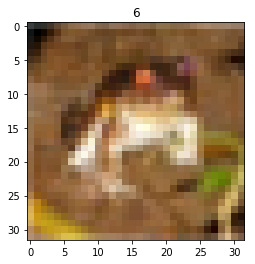

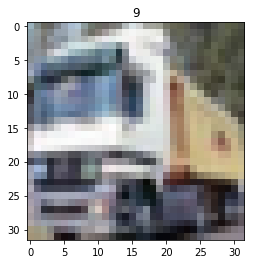

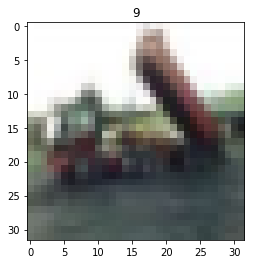

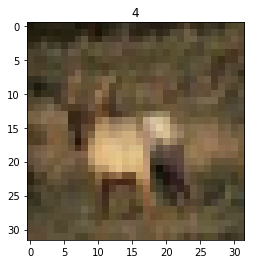

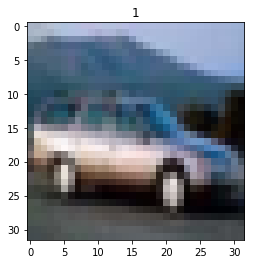

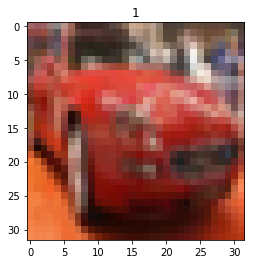

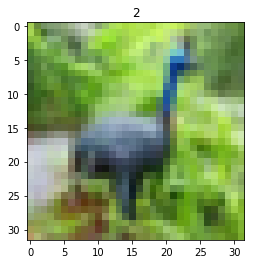

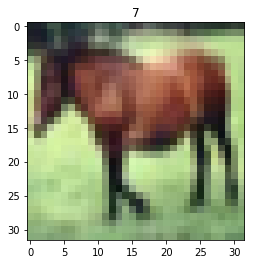

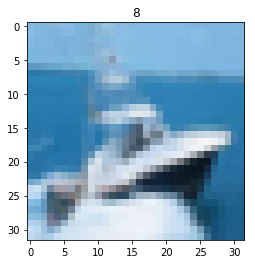

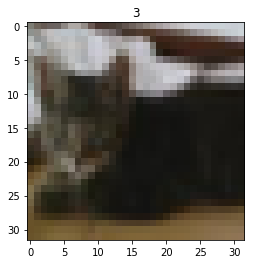

In [5]:
print(len(train_data.train_data))
print(len(train_data.train_labels))
for i in range(10):    
    img = np.asarray(train_data.train_data[i])
    plt.imshow(img, cmap='gray')
    plt.title('%i' % train_data.train_labels[i])
    plt.show()

In [6]:
test_data = torchvision.datasets.CIFAR10(root='./data/',
                              train=False,
                              transform=torchvision.transforms.ToTensor())

In [7]:
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                          batch_size=BATCH_SIZE,
                                          shuffle=False)

In [8]:
#test_data = torchvision.datasets.CIFAR10(root='./data/', train=False)
print(type(test_data.test_data))

############
#i dont's know way this type was 'numpy.ndarray', so i convert it myself
#test_data.test_data = torch.unsqueeze(torch.from_numpy(test_data.test_data), dim=3)
#print(type(test_data.test_data))
#print(len(test_data.test_data))
############


<class 'numpy.ndarray'>


In [9]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (3, 32, 32)
            nn.Conv2d(3,20,5,1,2),          # output shape (20, 32, 32)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (20, 16, 16)
        )
        self.conv2 = nn.Sequential(         # input shape (20, 16, 16)
            nn.Conv2d(20,40,5,1,2),         # output shape (40, 16, 16)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (40, 8, 8)
        )
        
        self.out1 = nn.Linear(40*8*8, 512)   # fully connected layer
        self.out2 = nn.Linear(512, 128)
        self.out3 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        #x = x.view(-1, 32 * 8 * 8)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = self.out1(x)
        x = self.out2(x)
        x = self.out3(x)
        return x    # return x for visualization

In [10]:
cnn = CNN()
cnn.cuda()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(20, 40, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out1): Linear(in_features=2560, out_features=512, bias=True)
  (out2): Linear(in_features=512, out_features=128, bias=True)
  (out3): Linear(in_features=128, out_features=10, bias=True)
)


In [11]:
print(list(cnn.parameters())[0].shape)

torch.Size([20, 3, 5, 5])


In [12]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)   # optimize all cnn parameters
#optimizer = torch.optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)
#loss_func = nn.NLLLoss()
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

In [13]:
def train(epoch):
    for step, (x, y) in enumerate(train_loader):
        data = Variable(x).cuda()   # batch x
        target = Variable(y).cuda()   # batch y

        output = cnn(data)               # cnn output
        loss = loss_func(output, target)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients

        if step % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, 
           step * len(data), len(train_loader.dataset),100. * step / len(train_loader), loss.data.item()))
    print("Finish")

def test():
    cnn.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data).cuda(), Variable(target).cuda()
        output = cnn(data)
        # sum up batch loss
        test_loss += loss_func(output, target)
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [14]:
for epoch in range(1,20):
    train(epoch)
    #test()

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.302536
Train Epoch: 1 [4000/50000 (8%)]	Loss: 1.911057
Train Epoch: 1 [8000/50000 (16%)]	Loss: 1.664028
Train Epoch: 1 [12000/50000 (24%)]	Loss: 1.580586
Train Epoch: 1 [16000/50000 (32%)]	Loss: 1.629317
Train Epoch: 1 [20000/50000 (40%)]	Loss: 1.536160
Train Epoch: 1 [24000/50000 (48%)]	Loss: 1.535479
Train Epoch: 1 [28000/50000 (56%)]	Loss: 1.464179
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.448496
Train Epoch: 1 [36000/50000 (72%)]	Loss: 1.201968
Train Epoch: 1 [40000/50000 (80%)]	Loss: 1.325456
Train Epoch: 1 [44000/50000 (88%)]	Loss: 1.418526
Train Epoch: 1 [48000/50000 (96%)]	Loss: 1.223872
Finish
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.193303
Train Epoch: 2 [4000/50000 (8%)]	Loss: 1.270189
Train Epoch: 2 [8000/50000 (16%)]	Loss: 1.137155
Train Epoch: 2 [12000/50000 (24%)]	Loss: 1.158044
Train Epoch: 2 [16000/50000 (32%)]	Loss: 1.106821
Train Epoch: 2 [20000/50000 (40%)]	Loss: 1.254653
Train Epoch: 2 [24000/50000 (48%)]	Loss: 1.015030
Train Epo

Train Epoch: 13 [32000/50000 (64%)]	Loss: 0.737364
Train Epoch: 13 [36000/50000 (72%)]	Loss: 0.734944
Train Epoch: 13 [40000/50000 (80%)]	Loss: 0.559283
Train Epoch: 13 [44000/50000 (88%)]	Loss: 0.515957
Train Epoch: 13 [48000/50000 (96%)]	Loss: 0.560181
Finish
Train Epoch: 14 [0/50000 (0%)]	Loss: 0.584806
Train Epoch: 14 [4000/50000 (8%)]	Loss: 0.588520
Train Epoch: 14 [8000/50000 (16%)]	Loss: 0.472713
Train Epoch: 14 [12000/50000 (24%)]	Loss: 0.530803
Train Epoch: 14 [16000/50000 (32%)]	Loss: 0.582385
Train Epoch: 14 [20000/50000 (40%)]	Loss: 0.483197
Train Epoch: 14 [24000/50000 (48%)]	Loss: 0.502400
Train Epoch: 14 [28000/50000 (56%)]	Loss: 0.556126
Train Epoch: 14 [32000/50000 (64%)]	Loss: 0.458554
Train Epoch: 14 [36000/50000 (72%)]	Loss: 0.591841
Train Epoch: 14 [40000/50000 (80%)]	Loss: 0.547650
Train Epoch: 14 [44000/50000 (88%)]	Loss: 0.689443
Train Epoch: 14 [48000/50000 (96%)]	Loss: 0.537904
Finish
Train Epoch: 15 [0/50000 (0%)]	Loss: 0.533638
Train Epoch: 15 [4000/50000 (8

In [15]:
test()

RuntimeError: CUDA out of memory. Tried to allocate 7.88 MiB (GPU 0; 1.95 GiB total capacity; 1.25 GiB already allocated; 10.00 MiB free; 528.50 KiB cached)